In [1]:
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import (make_blobs, make_circles, make_moons)
import pickle
from scipy.ndimage import label
from sklearn.preprocessing import MinMaxScaler

In [2]:
data1 = make_circles(factor=0.5, random_state=42, noise=0.05, n_samples=500)[0]
data2 = make_moons(n_samples=500, random_state=42, noise=0.05)[0]
data3 = make_blobs(n_samples=500, random_state=42, cluster_std=2)[0]
scaler = MinMaxScaler(feature_range=(0, 1))
if len(data1.shape) == 1:
    data1 = data1.reshape(-1, 1)
data1 = scaler.fit_transform(data1)
if len(data2.shape) == 1:
    data2 = data2.reshape(-1, 1)
data2 = scaler.fit_transform(data2)
if len(data3.shape) == 1:
    data3 = data3.reshape(-1, 1)
data3 = scaler.fit_transform(data3)

In [4]:
def gaussian(x, y, x0, y0, sigma=1):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

In [18]:
X = data3

In [115]:
s = 0.05

grid = 200
x = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, grid+1)
y = np.linspace(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1, grid+1)
x, y = np.meshgrid(x, y)

z = np.zeros_like(x)
for point in X:
    z += gaussian(x, y, point[0], point[1], s)

In [116]:
z.shape

(201, 201)

In [143]:
def plot_hill(hill, x, y, mask, title):
    global ball_z
    z = np.where(mask, hill, 0)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
    ax.set_title('3D Gaussian Plot over Dataset Points')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Intensity')
    plt.xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
    plt.ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    ax.set_zlim(0, 50)

    ball = 200
    ball_x = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, ball+1)
    ball_y = np.linspace(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1, ball+1)
    ball_x, ball_y = np.meshgrid(ball_x, ball_y)

    ball_z = np.array([[z[i][j] for j in np.arange(0, grid+grid//ball, grid//ball)] for i in np.arange(0, grid+grid//ball, grid//ball)])

    ax.scatter3D(ball_x[ball_z!=0], ball_y[ball_z!=0], ball_z[ball_z!=0], c='r', s=10)
    # ax.scatter3D(ball_x, ball_y, ball_z, c='r', s=3)
    plt.show()

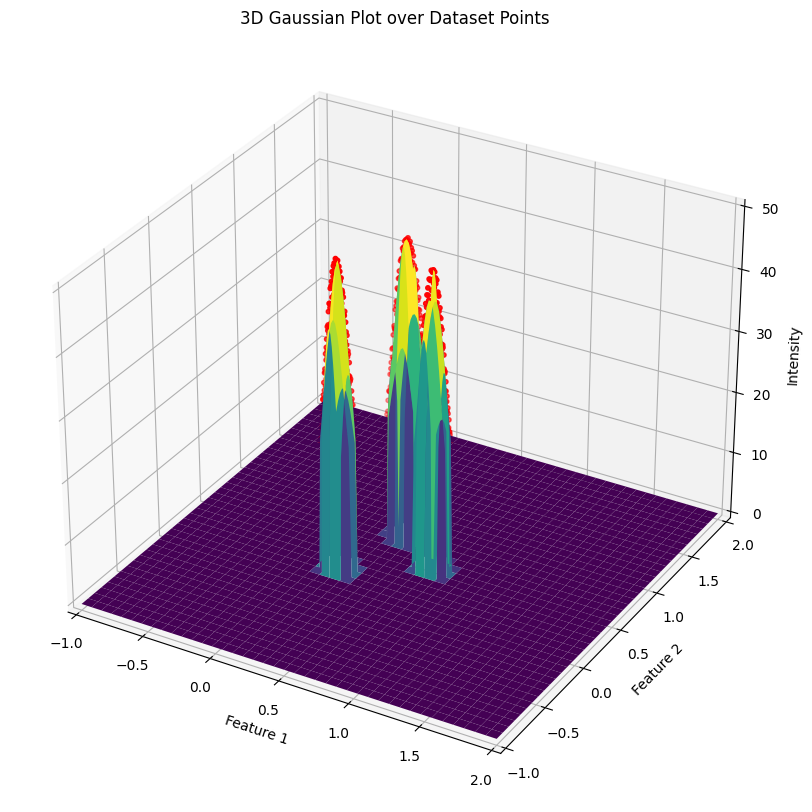

In [144]:
plot_hill(z, x, y, np.where(z<20, 0, 1), '3D Gaussian Plot over Dataset Points')

In [129]:
level_bin_array3[0].shape

(103, 103)

In [27]:
def plot_level_custom(level_bin_array, size1=1):
    gen_num = len(level_bin_array)
    rows = gen_num//5//5 + 1
    plt.figure(figsize=(size1*5, size1*rows))

    for i in range(len(level_bin_array)):
        if i%5 == 0:
            plt.subplot(rows, 5, i//5+1)
        else: continue
        plt.title(f"gen : {i}")
        plt.axis("off")
        plt.imshow(level_bin_array[i][::-1], cmap='gray', vmin=0, vmax=1)

    plt.show()

In [30]:
def simul_edge_custom(data, lim, grid, ball, sigma, hill_method=0, k=2): # grid//ball should be int
    X = data
    xlim, ylim = lim
    x = np.linspace(0, xlim, grid+1)
    y = np.linspace(0, ylim, grid+1)
    x, y = np.meshgrid(x, y)

    z = np.zeros_like(x)
    if hill_method == 0:
        for point in X:
            z += gaussian(x, y, point[0], point[1], sigma=sigma)
    elif hill_method == 1:
        for point in X:
            z += cone(x, y, point[0], point[1], sigma=sigma)

    # add ball
    ball_x = np.linspace(0, xlim, ball+1)
    ball_y = np.linspace(0, ylim, ball+1)
    ball_x, ball_y = np.meshgrid(ball_x, ball_y)

    ball_z = np.array([[z[i][j] for j in np.arange(0, grid+grid//ball, grid//ball)] for i in np.arange(0, grid+grid//ball, grid//ball)])

    # iter
    delta = [[-1, 0], [1, 0], [0, -1], [0, 1]]

    level = np.zeros((ball+3, ball+3))
    level[1:ball+2, 1:ball+2] = ball_z.copy()

    level_bin = np.zeros((ball+3, ball+3))
    level_bin[1:ball+2, 1:ball+2] = np.ones((ball+1, ball+1))

    edge = np.zeros((ball+3, ball+3))

    temp_clusters = []

    clusters_array = [temp_clusters]
    level_array = [level.copy()]
    level_bin_array = [level_bin]
    edge_array = []

    gen = 1
    edge = []

    reach_to_k = 0

    f1 = 1
    f2 = 1

    while np.any(level_bin == 1):
        if f1:
            f1 = 0
        else:
            if not reach_to_k:
                clusters, k_ = label(level_bin[1:-1, 1:-1] == 0)
                if k_ <= k:
                    reach_to_k = 1

        if not reach_to_k:
            temp = level.copy()
            temp_bin = level_bin.copy()
            for i in range(1, ball+2):
                for j in range(1, ball+2):
                    if not temp_bin[i, j]: continue
                    flag = 1
                    for d in delta:
                        if level[i+d[0], j+d[1]] > level[i, j]:  # 부등호에서 등호 삭제(edge 처리 문제)
                            flag = 0
                            break
                    if flag:
                        temp[i, j] = 0
                        temp_bin[i, j] = 0
        else:
            if f2:
                f2 = 0
                pad = np.zeros((ball+3, ball+3))
                pad[1:-1, 1:-1] = clusters
                clusters = pad.copy()
                clusters = clusters.astype(np.uint8)
            temp = level.copy()
            temp_bin = level_bin.copy()
            temp_clusters = clusters.copy()
            for i in range(1, ball+2):
                for j in range(1, ball+2):
                    if not temp_bin[i, j]: continue
                    flag = 1
                    for d in delta:
                        if level[i+d[0], j+d[1]] > level[i, j]:  # 부등호에서 등호 삭제(edge 처리 문제)
                            flag = 0
                            break
                    if flag:
                        types = []
                        for d in delta:
                            if 0<i+d[0] and i+d[0]<ball+2 and 0<j+d[1] and j+d[1]<ball+2: # ball+3 to ball+2
                                if temp_bin[i+d[0], j+d[1]] == 0:
                                    types.append(temp_clusters[i+d[0], j+d[1]])
                        if 0 in types: types.remove(0)
                        f3 = 0
                        if len(set(types)) > 1:
                            edge.append([i, j])
                            f3 = 1
                        temp[i, j] = 0
                        if f3:
                            temp_bin[i, j] = 0.5
                        else:
                            temp_bin[i, j] = 0
                        temp_clusters[i, j] = 0 if not types else types[0]

        gen += 1
        level_array.append(temp)

        level_bin_array.append(temp_bin)
        clusters_array.append(temp_clusters)

        level = temp
        level_bin = temp_bin
        clusters = temp_clusters

    bin_array = level_bin.copy()

    return level_bin_array, edge

In [32]:
level_bin_array3, edge3 = simul_edge_custom(data3, lim=(1, 1), grid=400, ball=100, sigma=0.05, k=3)